In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from timm import create_model

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:51<00:00, 3.31MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Define models
# ViT-L-16
model_vit = create_model('vit_large_patch16_224', pretrained=True)
model_vit.head = nn.Linear(model_vit.head.in_features, 10)  # Modify for CIFAR-10
model_vit = model_vit.to(device)

# BiT-M-101x3
model_bit = create_model('resnetv2_101x3_bitm', pretrained=True)
num_features = model_bit.num_features
model_bit.head = nn.Linear(num_features, 10)  # Modify for CIFAR-10
model_bit = model_bit.to(device)

# Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer_vit = optim.Adam(model_vit.parameters(), lr=1e-4)
optimizer_bit = optim.Adam(model_bit.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name resnetv2_101x3_bitm to current resnetv2_101x3_bit.goog_in21k_ft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/1.55G [00:00<?, ?B/s]

Train ViT-L-16:

In [ ]:
import torch
from tqdm import tqdm
import gc

# Training Function with GPU Memory Management and tqdm
def train_model(model, optimizer, loader, criterion, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        print(f"Epoch {epoch + 1}/{epochs}")
        progress_bar = tqdm(loader, desc="Training", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update tqdm progress bar
            progress_bar.set_postfix(loss=(running_loss / len(loader)))

            # Free GPU memory
            del images, labels, outputs, loss
            torch.cuda.empty_cache()
            gc.collect()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(loader)}")
        # Additional cleanup at the end of each epoch
        torch.cuda.empty_cache()
        gc.collect()

In [ ]:
# Train ViT and BiT models
print("Training ViT-L-16...")
train_model(model_vit, optimizer_vit, train_loader, criterion, device)

Training ViT-L-16...
Epoch 1/5


Epoch 1/5, Loss: 0.17340982138025512
Epoch 2/5


Epoch 2/5, Loss: 0.11444780288268029
Epoch 3/5


Epoch 3/5, Loss: 0.10229472782179357
Epoch 4/5


Epoch 4/5, Loss: 0.08419820483709445
Epoch 5/5


Epoch 5/5, Loss: 0.07650001912952925
Training BiT-M-101x3...
Epoch 1/5


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1376256x7 and 6144x10)

In [ ]:
# Save the trained ViT-L-16 model
torch.save(model_vit.state_dict(), "vit_l16_cifar10.pth")
print("ViT-L-16 model saved as vit_l16_cifar10.pth")

ViT-L-16 model saved as vit_l16_cifar10.pth


In [2]:
# conenct to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import os

# Change directory to the Google Drive folder
os.chdir('/content/drive/MyDrive/ECE Final')


In [4]:
!ls

 adv_loader_PGD.pt	     'Ensemble_Update (2).ipynb'   resnet56_cifar10.pth
 AttackWrappersWhiteBoxP.py   __pycache__		   ResNet56_WhiteBox.ipynb
 bit_m101x3_cifar10.pth       resnet50_cifar10.pth	   ResNetPytorch.py
 data			      resnet56-4bfd9763.th	   vit_b32_cifar10.pth
 DataManagerPytorch.py	      resnet56_cifar10_2.pth	   vit_l16_cifar10.pth


In [ ]:
# Save the trained ViT-L-16 model
torch.save(model_vit.state_dict(), "vit_l16_cifar10.pth")
print("ViT-L-16 model saved as vit_l16_cifar10.pth in Google Drive")

ViT-L-16 model saved as vit_l16_cifar10.pth in Google Drive


Load the model:

In [4]:
# Load the model
import torch
from timm import create_model
import torch.nn as nn

# Define the path to the saved model
model_path = "vit_l16_cifar10.pth"

# Load the ViT-L-16 model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vit = create_model('vit_large_patch16_224', pretrained=False)  # No pretrained weights here
model_vit.head = nn.Linear(model_vit.head.in_features, 10)  # Adjust for CIFAR-10
model_vit = model_vit.to(device)

# Load the trained weights
model_vit.load_state_dict(torch.load(model_path, map_location=device))
model_vit.eval()  # Set the model to evaluation mode

print("ViT-L-16 model loaded successfully.")


<ipython-input-4-2b245793adfb>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vit.load_state_dict(torch.load(model_path, map_location=device))


ViT-L-16 model loaded successfully.


In [5]:
import torch
from timm import create_model
import torch.nn as nn

# Define the path to the saved BiT-M-101x3 model
bit_model_path = "/content/drive/MyDrive/ECE Final/bit_m101x3_cifar10.pth"

# Load the BiT-M-101x3 model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bit = create_model('resnetv2_101x3_bitm', pretrained=False)  # No pretrained weights here
num_features = model_bit.num_features

# Adjust the head to match the saved structure
model_bit.head = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
    nn.Flatten(),                  # Flatten layer
    nn.Linear(num_features, 10)    # Fully Connected Layer for CIFAR-10
)

model_bit = model_bit.to(device)

# Load the trained weights
model_bit.load_state_dict(torch.load(bit_model_path, map_location=device))
model_bit.eval()  # Set the model to evaluation mode

print("BiT-M-101x3 model loaded successfully.")


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name resnetv2_101x3_bitm to current resnetv2_101x3_bit.goog_in21k_ft_in1k.
  model = create_fn(
<ipython-input-5-57e7ebfc7338>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full con

BiT-M-101x3 model loaded successfully.


Train Bit-M:

In [ ]:
# Update BiT-M classification head
model_bit.head = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
    nn.Flatten(),                  # Flatten the output
    nn.Linear(6144, 10)            # Fully Connected Layer for CIFAR-10
)
model_bit = model_bit.to(device)


In [ ]:
print("Training BiT-M-101x3...")
train_model(model_bit, optimizer_bit, train_loader, criterion, device)

Training BiT-M-101x3...
Epoch 1/5


Epoch 1/5, Loss: 0.4264461610940543
Epoch 2/5


Epoch 2/5, Loss: 0.22312245948117415
Epoch 3/5


Epoch 3/5, Loss: 0.15817588828390872
Epoch 4/5


Epoch 4/5, Loss: 0.11619868540811047
Epoch 5/5


Epoch 5/5, Loss: 0.09365247033355592


In [ ]:
# Save the trained model
import os

# Change directory to the Google Drive folder
os.chdir('/content/drive/MyDrive/661FinalProject')

# Save the trained ViT-L-16 model
torch.save(model_bit.state_dict(), "bit_m101x3_cifar10.pth")
print("bit_m101x3 model saved as bit_m101x3_cifar10.pth in Google Drive")

bit_m101x3 model saved as bit_m101x3_cifar10.pth in Google Drive


In [6]:
# Evaluate Model
def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [25]:
# Evaluate the individual models
vit_accuracy = evaluate_model(model_vit, test_loader, device)
bit_accuracy = evaluate_model(model_bit, test_loader, device)

print(f"ViT-L-16 Clean Accuracy: {vit_accuracy:.2f}%")
print(f"BiT-M-101x3 Clean Accuracy: {bit_accuracy:.2f}%")

ViT-L-16 Clean Accuracy: 95.08%
BiT-M-101x3 Clean Accuracy: 92.44%


In [7]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = models

    def forward(self, x):
        # Aggregate predictions (logits) from all models
        logits = [model(x) for model in self.models]
        avg_logits = torch.mean(torch.stack(logits), dim=0)  # Average logits
        return avg_logits  # Return averaged logits

In [8]:
# Create an ensemble model
ensemble_model = EnsembleModel([model_vit, model_bit])
ensemble_model.to(device)

EnsembleModel()

In [31]:
def evaluate_model_majority(model, loader, device):
    """
    Evaluates the ensemble model with majority voting.
    Assumes the model outputs class labels directly.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            predicted = model(images)  # Directly use the output as predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [33]:
# Evaluate the ensemble model on clean data
ensemble_accuracy = evaluate_model_majority(ensemble_model, test_loader, device)
print(f"Ensemble Model Clean Accuracy: {ensemble_accuracy:.2f}%")


Ensemble Model Clean Accuracy: 93.34%


###White-box Attacks

In [36]:
from AttackWrappersWhiteBoxP import FGSMNativePytorch, MIMNativePytorch

FGSM

In [41]:
# Parameters for attacks
epsilon = 0.031  # Perturbation magnitude
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using FGSMNativePytorch
adv_loader_FGSM = FGSMNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=ensemble_model,
    epsilonMax=epsilon,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)
print("Evaluating FGSM adversarial examples...")
fgsm_acc = evaluate_model(ensemble_model, adv_loader_FGSM, device)
print(f"FGSM Accuracy: {fgsm_acc:.2f}%")

Evaluating FGSM adversarial examples...
FGSM Accuracy: 35.96%


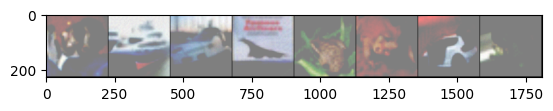

In [13]:
import torchvision
import matplotlib.pyplot as plt

# Get a batch of adversarial examples
for adv_images, labels in adv_loader_FGSM:
    break

# Unnormalize for visualization (assuming CIFAR-10 normalization)
adv_images = adv_images * 0.5 + 0.5  # If normalized to [-1, 1], reverse to [0, 1]

# Plot the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

MIM:

In [23]:
# MIM Attack on the Ensemble Model
epsilon = 0.031  # Maximum perturbation magnitude
epsilon_step = 0.00155  # Step size for each iteration
num_steps = 10  # Number of attack iterations
decay_factor = 1.0  # Momentum decay factor
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

adv_loader_MIM = MIMNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=ensemble_model,
    decayFactor=decay_factor,
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)
print("Evaluating MIM adversarial examples...")
mim_acc = evaluate_model(ensemble_model, adv_loader_MIM, device)
print(f"MIM Accuracy: {mim_acc:.2f}%")

Processing up to sample= 32
Processing up to sample= 64
Processing up to sample= 96
Processing up to sample= 128
Processing up to sample= 160
Processing up to sample= 192
Processing up to sample= 224
Processing up to sample= 256
Processing up to sample= 288
Processing up to sample= 320
Processing up to sample= 352
Processing up to sample= 384
Processing up to sample= 416
Processing up to sample= 448
Processing up to sample= 480
Processing up to sample= 512
Processing up to sample= 544
Processing up to sample= 576
Processing up to sample= 608
Processing up to sample= 640
Processing up to sample= 672
Processing up to sample= 704
Processing up to sample= 736
Processing up to sample= 768
Processing up to sample= 800
Processing up to sample= 832
Processing up to sample= 864
Processing up to sample= 896
Processing up to sample= 928
Processing up to sample= 960
Processing up to sample= 992
Processing up to sample= 1024
Processing up to sample= 1056
Processing up to sample= 1088
Processing up 

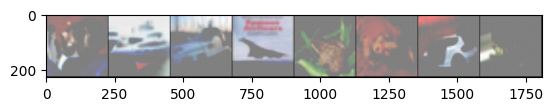

In [24]:
import torchvision
import matplotlib.pyplot as plt

# Get a batch of adversarial examples
for adv_images, labels in adv_loader_MIM:
    break

# Unnormalize for visualization (assuming CIFAR-10 normalization)
adv_images = adv_images * 0.5 + 0.5  # If normalized to [-1, 1], reverse to [0, 1]

# Plot the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

PGD:

In [9]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

def PGDNativePytorch(device, dataLoader, model, epsilonMax, epsilonStep, numSteps, clipMin, clipMax, targeted):
    """
    Implements the PGD attack with tqdm progress bar.
    """
    model.eval()  # Set model to evaluation mode
    # Generate variables for storing the adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)

    advSampleIndex = 0

    progress_bar = tqdm(dataLoader, desc="Generating PGD Adversarial Examples", leave=True)

    for xData, yData in progress_bar:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.shape[0]
        advImages = xData.clone().detach()

        # PGD iterations
        for _ in range(numSteps):
            advImages.requires_grad = True
            outputs = model(advImages)
            loss = torch.nn.CrossEntropyLoss()(outputs, yData)
            model.zero_grad()
            loss.backward()

            # Generate adversarial perturbations
            gradSign = advImages.grad.sign()
            if targeted:
                advImages = advImages - epsilonStep * gradSign  # Targeted: decrease towards target
            else:
                advImages = advImages + epsilonStep * gradSign  # Untargeted: increase loss

            # Project adversarial examples to epsilon-ball and clip to valid range
            advImages = torch.clamp(advImages, xData - epsilonMax, xData + epsilonMax)
            advImages = torch.clamp(advImages, clipMin, clipMax).detach()

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return DataLoader with adversarial examples
    advLoader = DataLoader(
        TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader


In [10]:

# Define PGD parameters
epsilon = 0.031  # Maximum perturbation magnitude
epsilon_step = 0.00155  # Step size
num_steps = 20  # Number of attack iterations
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using PGD
adv_loader_PGD = PGDNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=ensemble_model,
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

Generating PGD Adversarial Examples: 100%|██████████| 313/313 [1:42:25<00:00, 19.63s/it]


In [11]:
pgd_acc = evaluate_model(ensemble_model, adv_loader_PGD, device)
print(f"PGD Accuracy: {pgd_acc:.2f}%")

PGD Accuracy: 0.31%


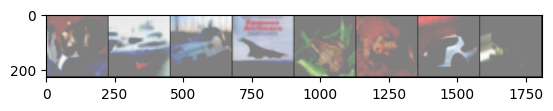

In [ ]:
import matplotlib.pyplot as plt
import torchvision
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_PGD:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5
# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [ ]:
import os
import torch

# Change directory to the Google Drive folder
os.chdir('/content/drive/MyDrive/ECE Final')

# Define the filename for saving the adversarial examples
adv_examples_path = "adv_loader_PGD.pt"

# Save the adversarial examples and corresponding labels
torch.save(list(adv_loader_PGD), adv_examples_path)

print(f"Adversarial examples saved successfully to {os.path.join(os.getcwd(), adv_examples_path)}")


Adversarial examples saved successfully to /content/drive/MyDrive/661FinalProject/adv_loader_PGD.pt


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [ ]:
import torch

torch.cuda.empty_cache()  # Frees up GPU memory allocated by PyTorch
torch.cuda.synchronize()  # Ensures all operations on the GPU are complete


###Transferability Test:

ViT-32

In [12]:
# Loading ViT-32
import torch
from timm import create_model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ViT model (ensure num_classes matches CIFAR-10)
vit_model = create_model('vit_base_patch32_224', pretrained=False, num_classes=10)
vit_model = vit_model.to(device)

# Load the pretrained weights for ViT
checkpoint_path = "vit_b32_cifar10.pth"  # Replace with your ViT weights path
vit_model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<ipython-input-12-ba8ad6869300>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load(checkpoint_path, map_location=device))


<All keys matched successfully>

In [13]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define transformations for ViT
vit_transform_train = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224 for ViT
    transforms.RandomCrop(224, padding=4),  # Optional data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

vit_transform_test = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset with ViT transformations
vit_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=vit_transform_train)
vit_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=vit_transform_test)

# Create DataLoaders for ViT
vit_train_loader = DataLoader(vit_train_dataset, batch_size=64, shuffle=True, num_workers=2)
vit_test_loader = DataLoader(vit_test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize

# Function to resize adversarial examples
def resize_adv_loader(adv_loader, target_size, device):
    """
    Resize adversarial examples to match the target model's input size.

    Args:
        adv_loader (DataLoader): DataLoader containing adversarial examples and labels.
        target_size (tuple): Target size (height, width) for resizing.
        device (torch.device): Device for computations.

    Returns:
        DataLoader: DataLoader with resized adversarial examples.
    """
    resized_images = []
    resized_labels = []

    for images, labels in adv_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Resize images
        resized = torch.nn.functional.interpolate(images, size=target_size, mode='bilinear', align_corners=False)
        resized_images.append(resized.cpu())
        resized_labels.append(labels.cpu())

    # Concatenate resized images and labels
    resized_images = torch.cat(resized_images)
    resized_labels = torch.cat(resized_labels)

    # Create a new DataLoader
    dataset = TensorDataset(resized_images, resized_labels)
    resized_loader = DataLoader(dataset, batch_size=adv_loader.batch_size, shuffle=False)

    return resized_loader

Resnet56:

In [15]:
from ResNetPytorch import resnet56

In [16]:
import torch
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ResNet-56 model (ensure num_classes matches CIFAR-10)
model_resnet = resnet56(inputImageSize=32, numClasses=10)
model_resnet = model_resnet.to(device)

# Define the path to the weights for ResNet-56
resnet_checkpoint_path = "resnet56_cifar10_2.pth"  # Replace with your ResNet weights path

# Load the pretrained weights for ResNet-56
model_resnet.load_state_dict(torch.load(resnet_checkpoint_path, map_location=device))
model_resnet.eval()  # Set the model to evaluation mode

print("ResNet-56 weights loaded successfully!")


<ipython-input-16-61a62c349b26>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet.load_state_dict(torch.load(resnet_checkpoint_path, map_location=device))


ResNet-56 weights loaded successfully!


In [17]:

# Define transformations for ViT
res_transform_train = transforms.Compose([
    transforms.Resize(32),  # Resize to 224x224 for ViT
    transforms.RandomCrop(224, padding=4),  # Optional data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

res_transform_test = transforms.Compose([
    transforms.Resize(32),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset with ViT transformations
res_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=res_transform_train)
res_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=res_transform_test)

# Create DataLoaders for ViT
res_train_loader = DataLoader(res_train_dataset, batch_size=64, shuffle=True, num_workers=2)
res_test_loader = DataLoader(res_test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [18]:
def evaluate_transferability(target_model, adv_loader, device):
    target_model.eval()
    correct = 0
    total = 0

    for adv_images, labels in adv_loader:
        adv_images, labels = adv_images.to(device), labels.to(device)

        # Test adversarial examples on the target model
        outputs = target_model(adv_images)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    transfer_success_rate = 100.0 * (1 - correct / total)

    return {
        'accuracy': accuracy,
        'transfer_success_rate': transfer_success_rate,
        'total_samples': total
    }


FGSM:

In [21]:
# Ensure the adversarial examples match the target model's input size
adv_loader_resized_FGSM = resize_adv_loader(
    adv_loader=adv_loader_FGSM,
    target_size=(224, 224),  # Input size for ViT
    device=device
)

# Evaluate transferability on the ViT model
results_FGSM_transferability = evaluate_transferability(
    target_model=vit_model,
    adv_loader=adv_loader_resized_FGSM,
    device=device
)

# Print the results
print(f"Accuracy on FGSM adversarial examples: {results_FGSM_transferability['accuracy']:.2f}%")
print(f"Transferability Success Rate: {results_FGSM_transferability['transfer_success_rate']:.2f}%")

Accuracy on FGSM adversarial examples: 42.08%
Transferability Success Rate: 57.92%


In [22]:
# Ensure the adversarial examples match the target model's input size
adv_loader_resized_FGSM = resize_adv_loader(
    adv_loader=adv_loader_FGSM,  # Replace with your PGD adversarial loader
    target_size=(32, 32),  # Input size for ResNet56
    device=device
)

# Evaluate transferability on the ResNet56 model
results_FGSM_transferability_resnet = evaluate_transferability(
    target_model=model_resnet,
    adv_loader=adv_loader_resized_FGSM,
    device=device
)

# Print the results
print(f"Accuracy on FGSM adversarial examples (ResNet56): {results_FGSM_transferability_resnet['accuracy']:.2f}%")
print(f"Transferability Success Rate (ResNet56): {results_FGSM_transferability_resnet['transfer_success_rate']:.2f}%")


/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Accuracy on FGSM adversarial examples (ResNet56): 31.78%
Transferability Success Rate (ResNet56): 68.22%


MIM:

In [26]:
# Ensure the adversarial examples match the target model's input size
adv_loader_resized_MIM = resize_adv_loader(
    adv_loader=adv_loader_MIM,
    target_size=(224, 224),  # Input size for ViT
    device=device
)

# Evaluate transferability on the ViT model
results_MIM_transferability = evaluate_transferability(
    target_model=vit_model,
    adv_loader=adv_loader_resized_MIM,
    device=device
)

# Print the results
print(f"Accuracy on MIM adversarial examples: {results_MIM_transferability['accuracy']:.2f}%")
print(f"Transferability Success Rate: {results_MIM_transferability['transfer_success_rate']:.2f}%")

Accuracy on MIM adversarial examples: 41.20%
Transferability Success Rate: 58.80%


In [27]:
# Ensure the adversarial examples match the target model's input size
adv_loader_resized_MIM = resize_adv_loader(
    adv_loader=adv_loader_MIM,  # Replace with your PGD adversarial loader
    target_size=(32, 32),  # Input size for ResNet56
    device=device
)

# Evaluate transferability on the ResNet56 model
results_MIM_transferability_resnet = evaluate_transferability(
    target_model=model_resnet,
    adv_loader=adv_loader_resized_MIM,
    device=device
)

# Print the results
print(f"Accuracy on MIM adversarial examples (ResNet56): {results_MIM_transferability_resnet['accuracy']:.2f}%")
print(f"Transferability Success Rate (ResNet56): {results_MIM_transferability_resnet['transfer_success_rate']:.2f}%")


/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Accuracy on MIM adversarial examples (ResNet56): 32.49%
Transferability Success Rate (ResNet56): 67.51%


PGD:

In [19]:
# Ensure the adversarial examples match the target model's input size
adv_loader_resized_PGD = resize_adv_loader(
    adv_loader=adv_loader_PGD,
    target_size=(224, 224),  # Input size for ViT
    device=device
)

# Evaluate transferability on the ViT model
results_PGD_transferability = evaluate_transferability(
    target_model=vit_model,
    adv_loader=adv_loader_resized_PGD,
    device=device
)

# Print the results
print(f"Accuracy on PGD adversarial examples: {results_PGD_transferability['accuracy']:.2f}%")
print(f"Transferability Success Rate: {results_PGD_transferability['transfer_success_rate']:.2f}%")

Accuracy on PGD adversarial examples: 41.49%
Transferability Success Rate: 58.51%


In [20]:
# Ensure the adversarial examples match the target model's input size
adv_loader_resized_PGD = resize_adv_loader(
    adv_loader=adv_loader_PGD,  # Replace with your PGD adversarial loader
    target_size=(32, 32),  # Input size for ResNet56
    device=device
)

# Evaluate transferability on the ResNet56 model
results_PGD_transferability_resnet = evaluate_transferability(
    target_model=model_resnet,
    adv_loader=adv_loader_resized_PGD,
    device=device
)

# Print the results
print(f"Accuracy on PGD adversarial examples (ResNet56): {results_PGD_transferability_resnet['accuracy']:.2f}%")
print(f"Transferability Success Rate (ResNet56): {results_PGD_transferability_resnet['transfer_success_rate']:.2f}%")


/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Accuracy on PGD adversarial examples (ResNet56): 32.21%
Transferability Success Rate (ResNet56): 67.79%
